In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [23]:
class InterDiode:
    
    def __init__(self, name = "Lakeshore DT-670", data_file = "lakeshore.txt"):
        self.data_loaded = False
        self.name = name
        self.load_data(data_file) #Needs data in 3 column text file with columns T, V, dV/dT
    

    def load_data(self, data_file):
        self.data = np.loadtxt(data_file) #Columns are T, V, dV/dT

        self.data = self.data[self.data[:,1].argsort()] #Sorting by voltage, column 1 so that splrep works properly

        self.temp = self.data[:,0]
        self.volt = self.data[:, 1]
        self.dvdt = self.data[:, 2]
        self.data_loaded = True
        #Get the spline object
        self.spln = interpolate.splrep(self.volt, self.temp, k=3)
        
    def interpolateDiode(self,interx):
        if(self.data_loaded) and (interx > self.data[:, 1][0] and interx < self.data[:, 1][-1]):
            return interpolate.splev(interx, self.spln)
        elif (self.data_loaded):
            print("Beware, extrapolating!")
            return interpolate.splev(interx, self.spln)
        else:
            print("Loading data...")
            self.load_data(self.data_file)
            return interpolate.splev(interx, self.spln)


In [31]:
#Initiate an instance of the default class (Lakeshore DT 670)
dt670 = InterDiode()
#Interpolate what temperature would give a voltage of 0.19 at 10 uA current. 
dt670.interpolateDiode(0.009)

Beware, extrapolating!


array(545.29313277)

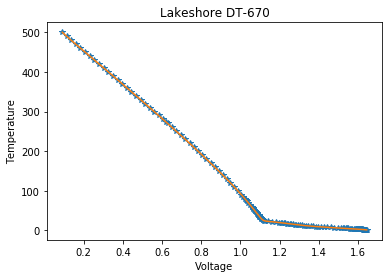

In [38]:
#Checking interpolation across full range
interx = np.linspace(dt670.volt[0], dt670.volt[-1], 1000)
intery = interpolate.splev(interx, dt670.spln)

plt.plot(dt670.volt, dt670.temp, '*')
plt.plot(interx, intery, '-')
plt.xlabel('Voltage')
plt.ylabel('Temperature')
plt.title(dt670.name)

